# 🎸 Object Detection using YOLOv8 on Custom Guitar Dataset 🎸



The goal is to detect guitars in images using the YOLOv8 model. YOLOv8 is a state-of-the-art YOLO model that can be used for object detection, image classification, and instance segmentation tasks. YOLOv8 is fast, accurate, and easy to use. In this project, it has been used to detect guitars.

#### Overview of the workflow in this notebook:

1. Set up the Google Colab
2. YOLOv8 Installation
3. Mount the Google Drive
4. Visualize the train images with their bounding boxes
5. Create the Guitar_v8.yaml (dataset config file) (YOLOv8 format)
6. Train the custom Guitar Detection model
7. Run Inference with the custom YOLOv8 Object Detector Trained Weights
8. Visualize the Predictions by plotting the validation images and their predicted bounding boxes

## 🎸 Import the necessary libraries 🎸

In [1]:

!nvidia-smi

Fri Dec  8 13:52:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
 1695884081.2863135
 1695884081.3142548
 1695884126.3520193
 1695884126.3613842
 annotaion_person_draw0.zip
 annotaion_person_draw.zip
 Audio2Head
 chip1.py
 coco_person_car_yolov4_22000.weights
'Colab Notebooks'
 config.json
'Copy of Copy of Copy of yolov4-custom_TRAINING_vf.ipynb'
'Copy of Copy of custom_yoloV5.ipynb'
'Copy of Copy of productCount_final_custom_yolov3.ipynb'
 events.out.tfevents.1695884081.a48e7dd1b69d.18859.0
 events.out.tfevents.1695884126.a48e7dd1b69d.19062.0
 Face_Recognition
 fake_review
'Fraser (1).docx'
 Fraser.gdoc
 GAN
'Gan_model '
 indian_test_team.jpg
 kaggle.json
'Latest Screenshots.docx'
 LipGAN
 model.py
'My Drive'
 new_annotation
 preprocessor_config.json
 pretrained_models.zip
'Proposal for VA - FT.docx'
'Proposal for VA - FT - High level assumptions - feasibility  (1).gdoc'
'Proposal for VA - FT - High level assumptions - feasibility .gdoc'
 PySpark.gdoc
 scheduler_config.json
 speech-text_custom_train_all_pretrained
 task_h

In [3]:
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os
from google.colab.patches import cv2_imshow

In [4]:
# install ultralytics

!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.1/660.1 kB 13.0 MB/s eta 0:00:00


## 🎸 Dataset 🎸

The dataset has been created by me. First, the copyright free images were collected from websites. Thereafter, they were annotated carefully using free labelling softwares available online. Attention was paid during labelling to maintain consistency of annotations. Cross-checking was done several times to avoid any discrepancy and ensuring the quality of the dataset.

The dataset has 2 folders:

train - contains 280 images. Out of these 280 images, 248 have one or more guitars in them, while the rest 32 images are only background having no guitar in them. These 32 background images are kept in the training dataset in order to penalize the False Positives. 'False Positives' (also known as 'Type I error') means that the model falsely makes a positive prediction when actually the condition (in this case, a guitar) does not exist. The background images (~ 10% of the size of the dataset) help the model in learning the case when a guitar is not present in the dataset. Hence, it penalizes the false positive and improves the Precision of the prediction.

val - contains 20 images. Care has been taken to prevent any data leakage. Any image present in the train set is not a part of the val set.

Hence, effort has been made to create a good quality dataset because the quality of the predictions depends a lot on the quality of the dataset the model has been trained on.

Structure of the dataset:

number of classes in the dataset = 1

classes = "Guitar"

Guitar_dataset

|__ train

----|______ images

----|______ labels

|__ val

----|______ images

----|______ labels

Note: Object detection requires large datasets. In this project, only in-built augmentation available with the YOLOv8 model during training has been used on the dataset. An analysis of the quality of augmentation has not been performed, as it is an iterative process and requires a lot of trial and error to get the right quality of augmentation. Also, the quality of augmentation plays a major role in the quality of predictions in object detection.

The dataset is loaded from the Google Drive.

## 🎸 For object detection, the bounding box coordinates for the data can be in many different formats 🎸

1. x_min, y_min, x_max, y_max
2. x1, y1, x2, y2
3. coco format: x, y, w, h
4. yolo format: x_center_normalized, y_center_normalized, bbox_w_normalized, bbox_h_normalized

To convert the bounding boxes from the yolo format to x_min, y_min, x_max, y_max, perform the following operation.

In [5]:
! cp -r /content/gdrive/MyDrive/yolov8_iphone_hair_scratch/iphone_hair_scratch_dataset_merged.v2i.yolov5pytorch /content

cp: cannot create regular file '/content/iphone_hair_scratch_dataset_merged.v2i.yolov5pytorch/valid/labels/33_jpg.rf.5349ecb6f74deea17d4e8960469255c8.txt': No such file or directory
cp: cannot create regular file '/content/iphone_hair_scratch_dataset_merged.v2i.yolov5pytorch/valid/labels/13_jpg.rf.72ff84de56a2bc0f2264aa27b20f7f31.txt': No such file or directory
cp: cannot create regular file '/content/iphone_hair_scratch_dataset_merged.v2i.yolov5pytorch/valid/labels/hair41_jpg.rf.62e121d7e02d2e20a5802cfea7ad5a66.txt': No such file or directory
cp: cannot create regular file '/content/iphone_hair_scratch_dataset_merged.v2i.yolov5pytorch/valid/labels/hair35_jpg.rf.559736ab17db59636ddf0d9ed115925a.txt': No such file or directory
cp: cannot create regular file '/content/iphone_hair_scratch_dataset_merged.v2i.yolov5pytorch/valid/labels/hair37_jpg.rf.e53e07541b419dc7ec8efa5434c3f916.txt': No such file or directory


In [6]:
# Function to convert bounding boxes in YOLO format to x_min, y_min, x_max, y_max.

def yolo2bbox(bboxes):
    """
    Argument: bboxes
    The function takes bboxes as input containing the YOLO bounding box coordinates.
    It then calculates the (xmin, ymin) and (xmax, ymax) coordinates of the bounding box.
    Returns the coordinates: xmin, ymin, xmax, ymax
    """

    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [7]:
# Function to plot the bounding boxes.

def plot_box(image, bboxes, labels):
    """
    Arguments:  image - an input image,
                bboxes - a list of bounding boxes in YOLO format,
                labels - a list of labels corresponding to each bounding box.
    The function plots the bounding boxes on the image using OpenCV (cv2).
    Returns the modified image.
    """

    # Need the image height and width to denormalize the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)

        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        # calculate the thickness of the bounding box lines based on the image width
        # to make sure the boxes are visible in the plot.
        thickness = max(2, int(w/275))

        # draw a rectangle on the image
        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            #  color (0, 0, 255) -> red
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [8]:
# Function to plot images with the bounding boxes.

def plot(image_paths, label_paths, num_samples):
    """
    Arguments:  image_paths - the path to the folder containing the images.
                label_paths - the path to the folder containing the label files for the corresponding images.
                num_samples - the number of random samples to visualize.
    The function helps to visualize a random selection of images along with their bounding boxes and labels.
    """

    all_images = []     #  initialize an empty list to store the paths of all the image files

    # the glob module is used to find image files (with ".jpg" or ".JPG" extensions) in the specified image_paths folder
    # and append them to all_images.
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()   # sort the all_images list to ensure a consistent order of images during random selection.

    num_images = len(all_images)    # find the number of images in all_images list

    plt.figure(figsize=(15, 12))    # create a plot of 15x12 inches

    for i in range(num_samples):
        j = random.randint(0,num_images-1)  # variable j represents the index of the image that will be randomly selected
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])   # read the image corresponding to the index j.

        # open the label file associated with the selected image (based on the image name)
        # read the bounding box coordinates and labels for each object present in the image.
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []     # initialize an empty list to store the bounding box coordinates that are extracted from the label files.
            labels = []     # initialize an empty list to store the labels that are extracted from the label files.
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)  # call the plot_box function to draw the bounding boxes and labels on the image.
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])    # reverse the order of color channels. OpenCV uses BGR color order. Matplotlib uses RGB color order.
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

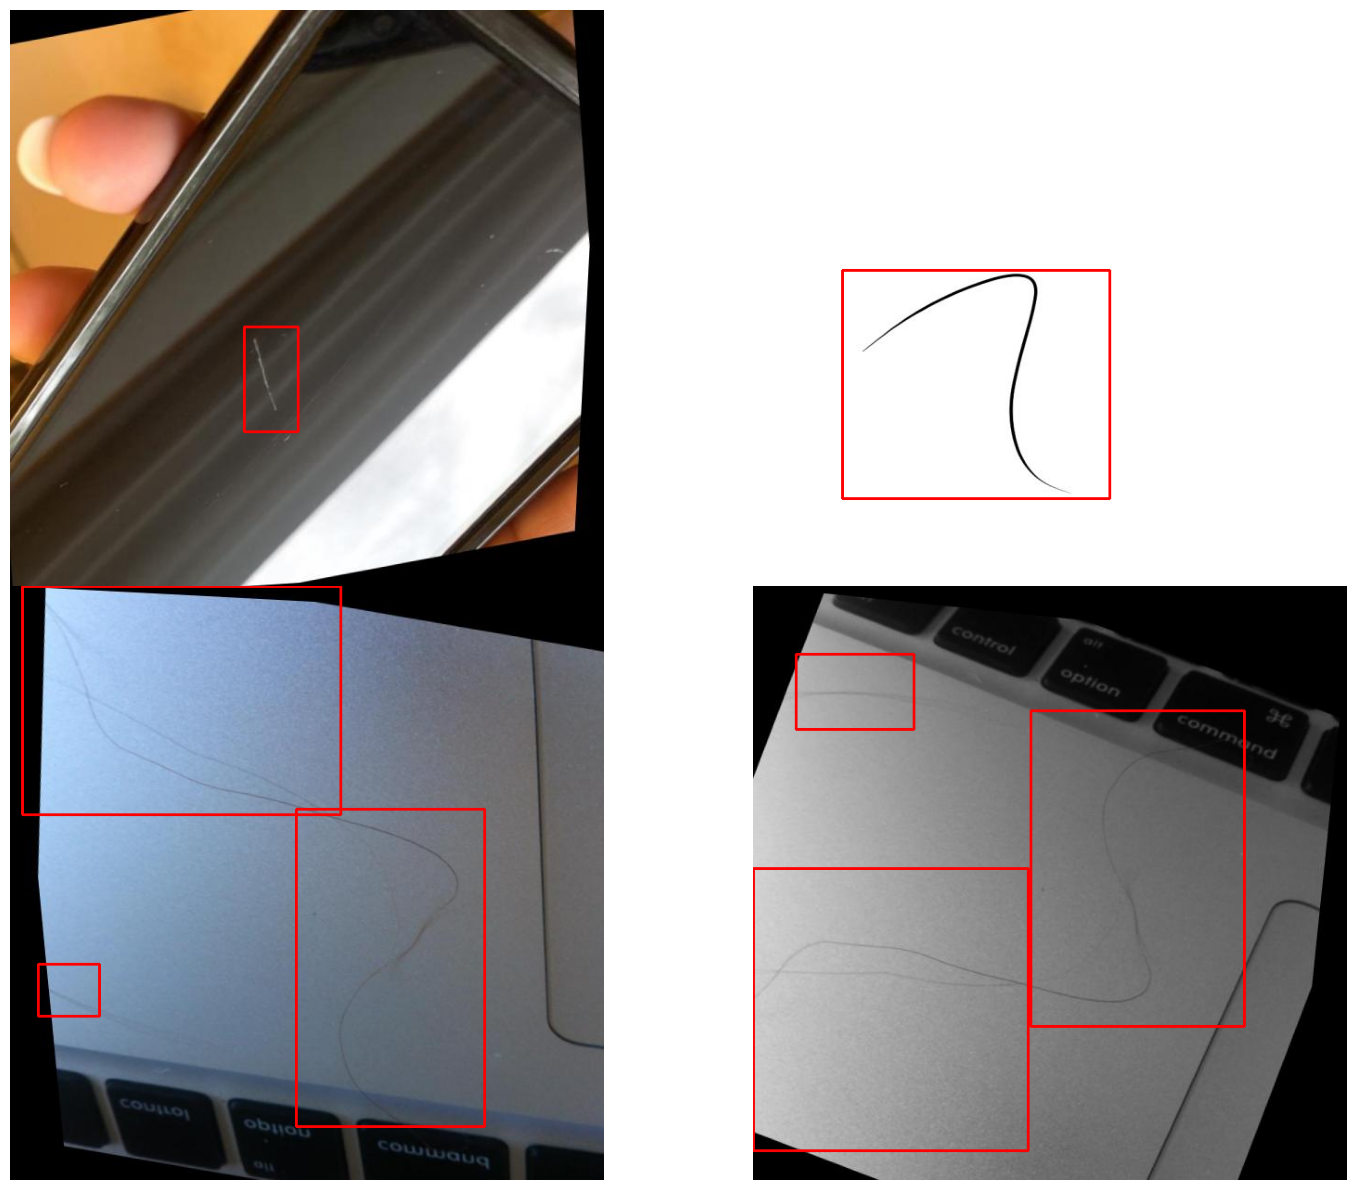

In [10]:
# Visualize a few training images.

plot(
    image_paths='/content/yolov8_iphone_hair_scratch_dataset/train/images',
    label_paths='/content/yolov8_iphone_hair_scratch_dataset/train/labels',
    num_samples=4,
)

Note: The guitar images have been annotated only for the front view of the guitar even in case the side view is visible. Effort has been made to maintain consistency for this annotation.

In [11]:
# Create a YAML configuration file named Guitar_v8.yaml.
# The file contains the paths to the train and validation image directories for a Guitar dataset
# along with the class name mapping.
'''
%%writefile Guitar_v8.yaml
path: '/content/drive/MyDrive/Guitar_dataset'
train: '/content/drive/MyDrive/Guitar_dataset/train/images'
val: '/content/drive/MyDrive/Guitar_dataset/val/images'

# class names
names:
  0: 'Guitar'

'''
'''
import yaml

football_yaml = dict(
    train ='/content/yolov8_iphone_hair_scratch_dataset/train',
    val ='/content/yolov8_iphone_hair_scratch_dataset/valid',
    test='/content/yolov8_iphone_hair_scratch_dataset/test',
    nc =2,
    names =['hair', 'scratch']
)

with open('/content/yolov8_iphone_hair_scratch_dataset/data.yaml', 'w') as outfile:
    yaml.dump(football_yaml, outfile, default_flow_style=True)

'''
import yaml
config = {'path': '/content/yolov8_iphone_hair_scratch_dataset',
         'train': '/content/yolov8_iphone_hair_scratch_dataset/train',
         'val': '/content/yolov8_iphone_hair_scratch_dataset/test',
         'nc': 2,
         'names': ['hair', 'scratch']}

with open("/content/yolov8_iphone_hair_scratch_dataset/data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

#%cat /content/yolov8_iphone_hair_scratch_dataset/data.yaml

In [12]:
%cat /content/yolov8_iphone_hair_scratch_dataset/data.yaml

names:
- hair
- scratch
nc: 2
path: /content/yolov8_iphone_hair_scratch_dataset
train: /content/yolov8_iphone_hair_scratch_dataset/train
val: /content/yolov8_iphone_hair_scratch_dataset/test


In [13]:
# Specify the number of epochs and batch size for training.

EPOCHS = 1000
BATCH=16

 ## 🎸 Train the YOLOv8 model (yolov8n.pt) with the specified parameters. The training configuration is defined in the Guitar_v8.yaml file 🎸

!yolo: Run the YOLO task.

task=detect: Specify the type of task, which is detection in this case.

mode=train: Indicate that the model will be trained.

model=yolov8n.pt: Specify the pre-trained YOLOv8 model to use as a starting point for training.

imgsz=640: Set the input image size for training to 640x640 pixels.

data=/content/Guitar_v8.yaml: Specify the path to the YAML configuration file (Guitar_v8.yaml) containing the dataset and class information.

epochs={EPOCHS}: Set the number of training epochs.

batch={BATCH}: Set the batch size for training.

augment=True: Augment the images using albumentation.

name=yolov8n_v8_50e: Specify a name for the training run, likely to be used for saving checkpoints and logs related to this training session.

In [14]:
# Train the YOLOv8 model.

!yolo task=detect \
mode=train \
model=yolov8m.pt \
imgsz=640 \
data=/content/yolov8_iphone_hair_scratch_dataset/data.yaml \
epochs={EPOCHS} \
batch={BATCH} \
augment=True \
patience=0 \
name=yolov8n_v8_1000e

Streaming output truncated to the last 5000 lines.
     4/1000      7.18G      2.241      2.823       2.23         38        640: 100% 12/12 [00:02<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00, 11.23it/s]
                   all         10         24   0.000753      0.133   0.000455   0.000166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     5/1000      7.18G      2.217      2.673      2.217         63        640: 100% 12/12 [00:02<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  9.44it/s]
                   all         10         24     0.0013      0.122   0.000902   0.000103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     6/1000      7.15G      2.293      2.719      2.215         47        640: 100% 12/12 [00:02<00:00,  5.47it/s]
                 Cla

## 🎸 Evaluate the trained YOLOv8 model on a validation dataset 🎸

!yolo: Run the YOLO task.

task=detect: Specify the type of task, which is detection in this case.

mode=val: Indicate that the model will be validated.

model=/content/runs/detect/yolov8n_v8_50e/weights/best.pt: Specifiy the path to the trained YOLOv8 model's weights file. The path provided points to the best-performing weights checkpoint saved during training.

name=yolov8n_eval: Set a name for the evaluation run, which could be used to identify and organize the evaluation results.

data=/content/Guitar_v8.yaml: Specify the path to the YAML configuration file (Guitar_v8.yaml) containing the dataset and class information.

In [14]:
# Evaluate the trained model on the validation set using the trained model's weights file.

!yolo task=detect \
mode=val \
model=/content/runs/detect/yolov8n_v8_1000e/weights/best.pt \
name=yolov8n_eval \
data=/content/yolov8_iphone_hair_scratch_dataset/data.yaml

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/yolov8_iphone_hair_scratch_dataset/test/labels.cache... 16 images, 0 backgrounds, 0 corrupt: 100% 16/16 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  1.44it/s]
                   all         16         37      0.663       0.43      0.516      0.244
                  hair         16         18      0.734      0.333       0.53      0.253
               scratch         16         19      0.593      0.526      0.502      0.236
Speed: 0.2ms preprocess, 7.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/yolov8n_eval
💡 Learn more at https://docs.ultralytics.com/modes/val


## 🎸 Metrics Evaluation 🎸

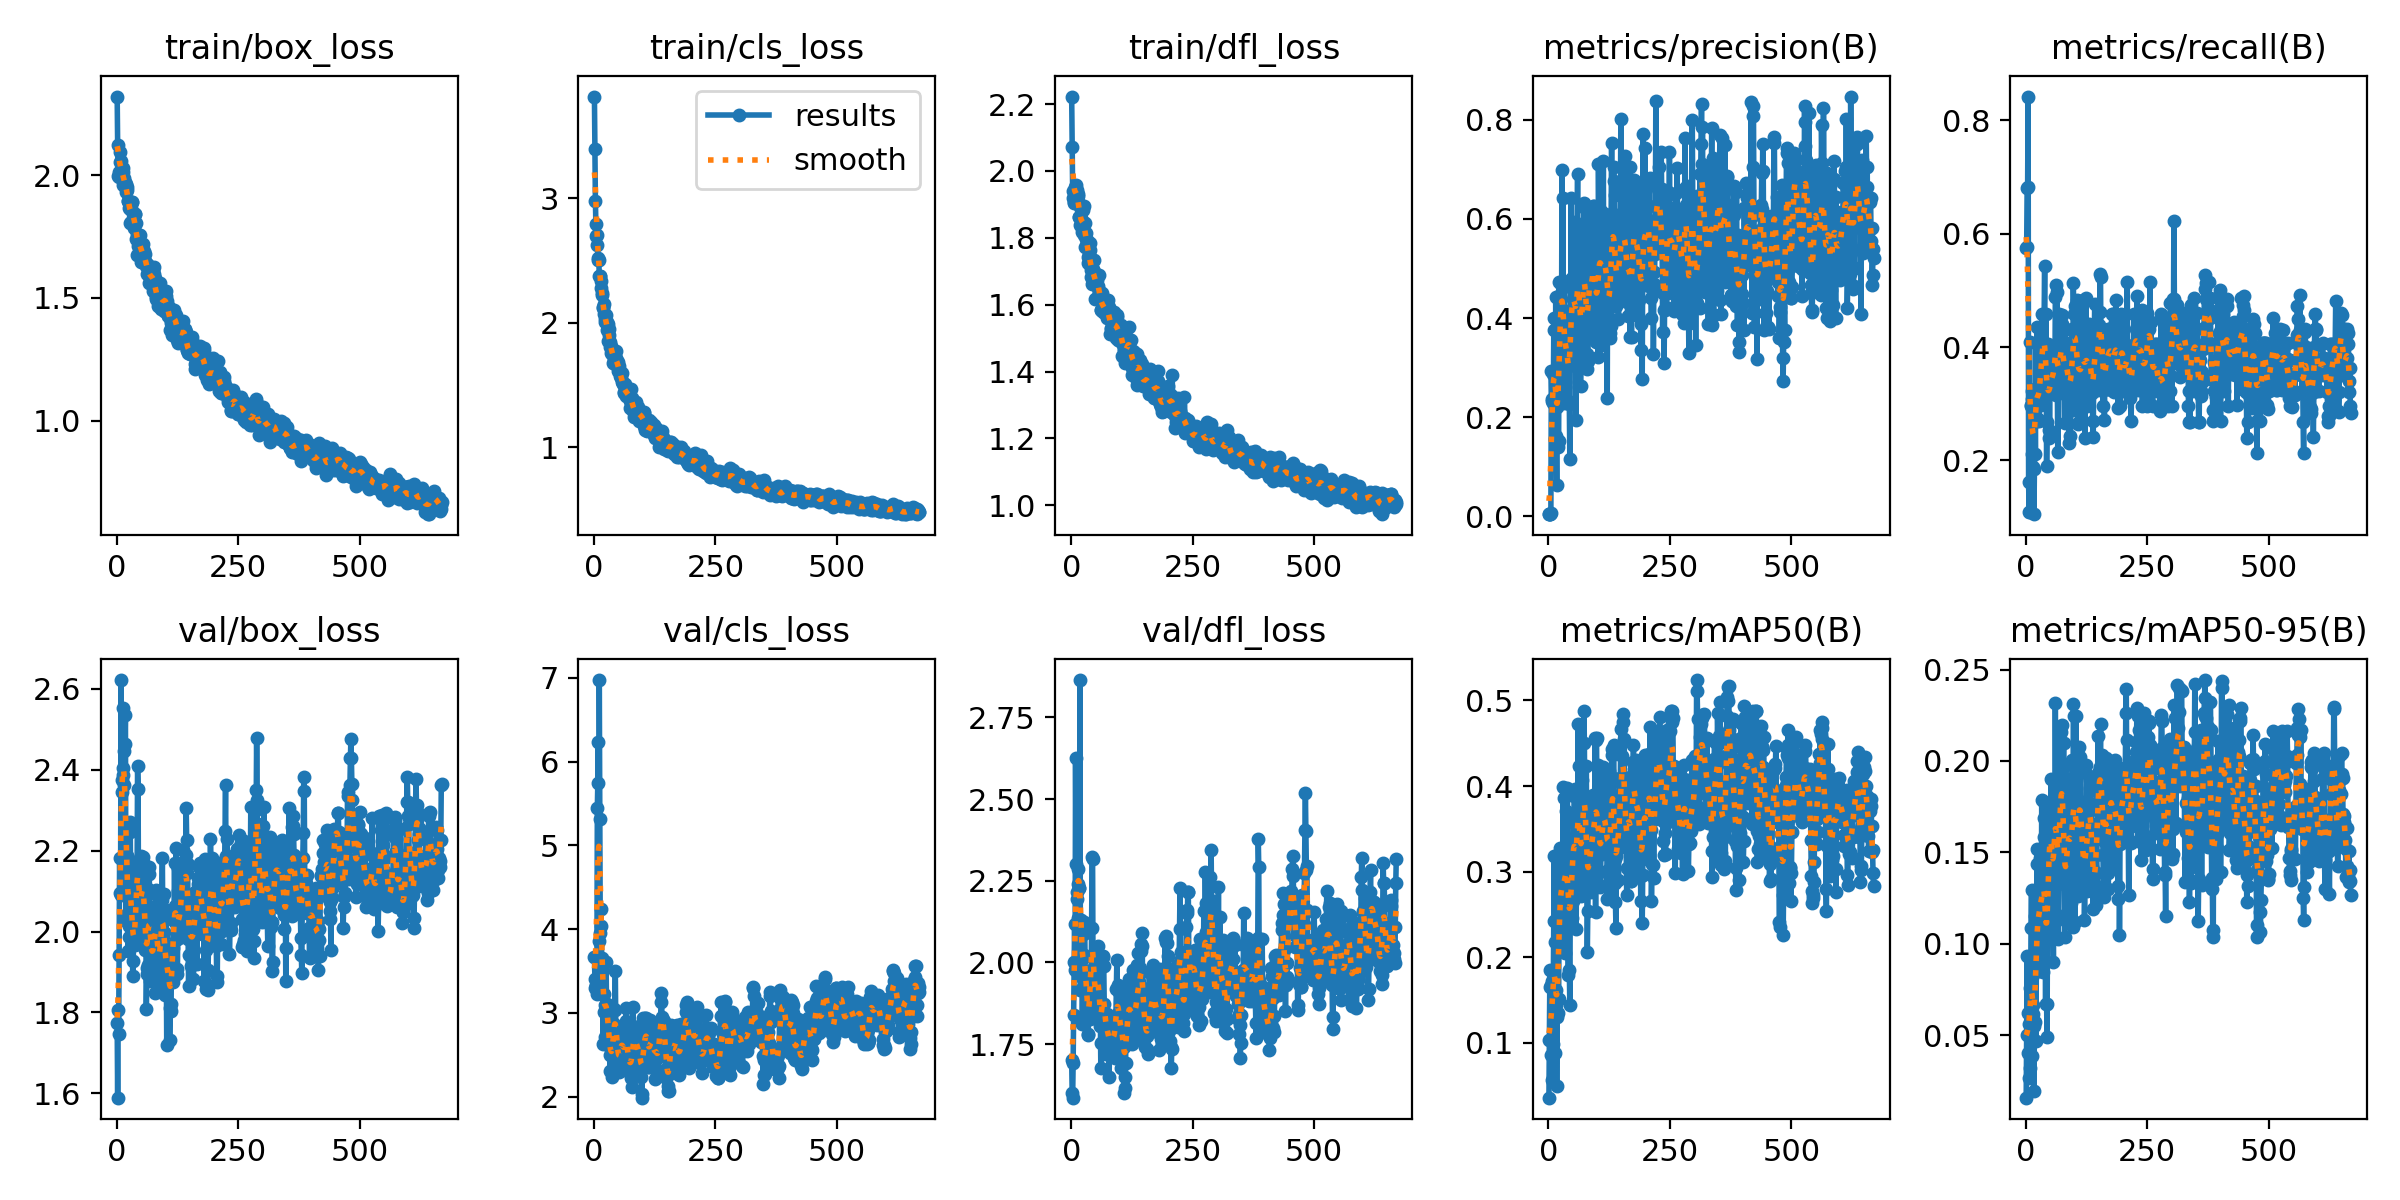

In [15]:
cv2_imshow(cv2.imread("/content/runs/detect/yolov8n_v8_1000e/results.png"))

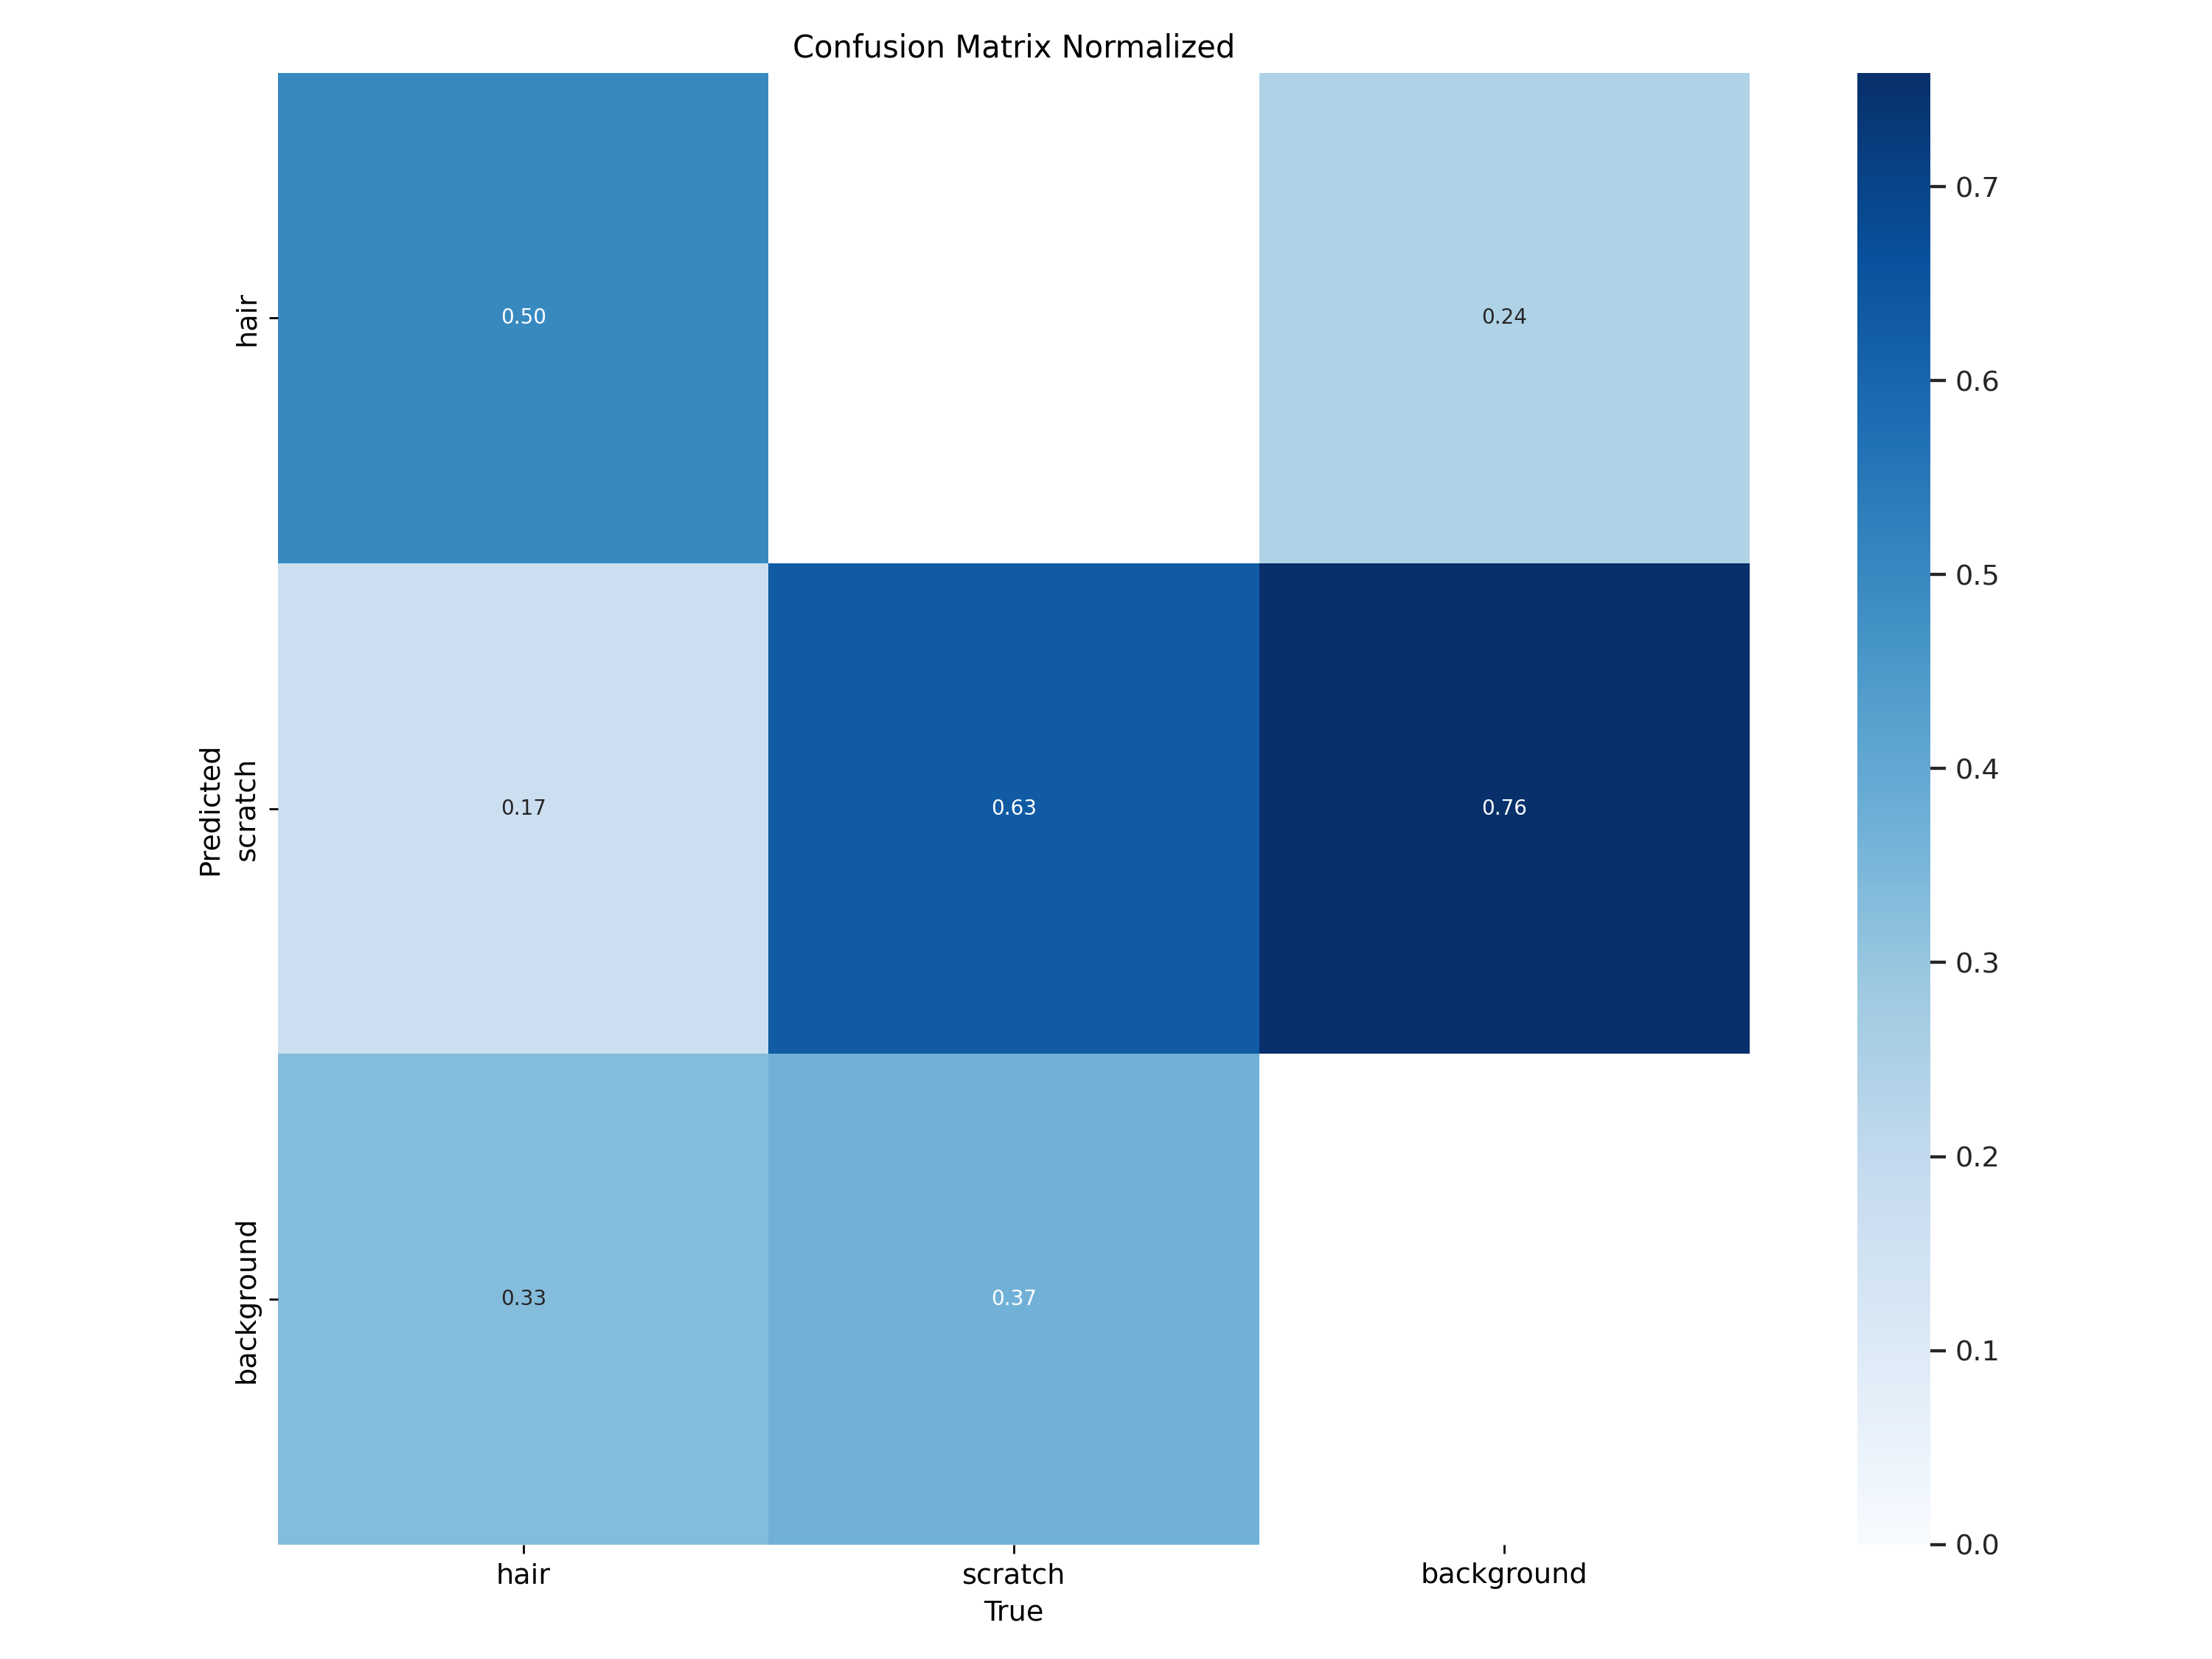

In [16]:
cv2_imshow(cv2.imread("/content/runs/detect/yolov8n_v8_1000e/confusion_matrix_normalized.png"))

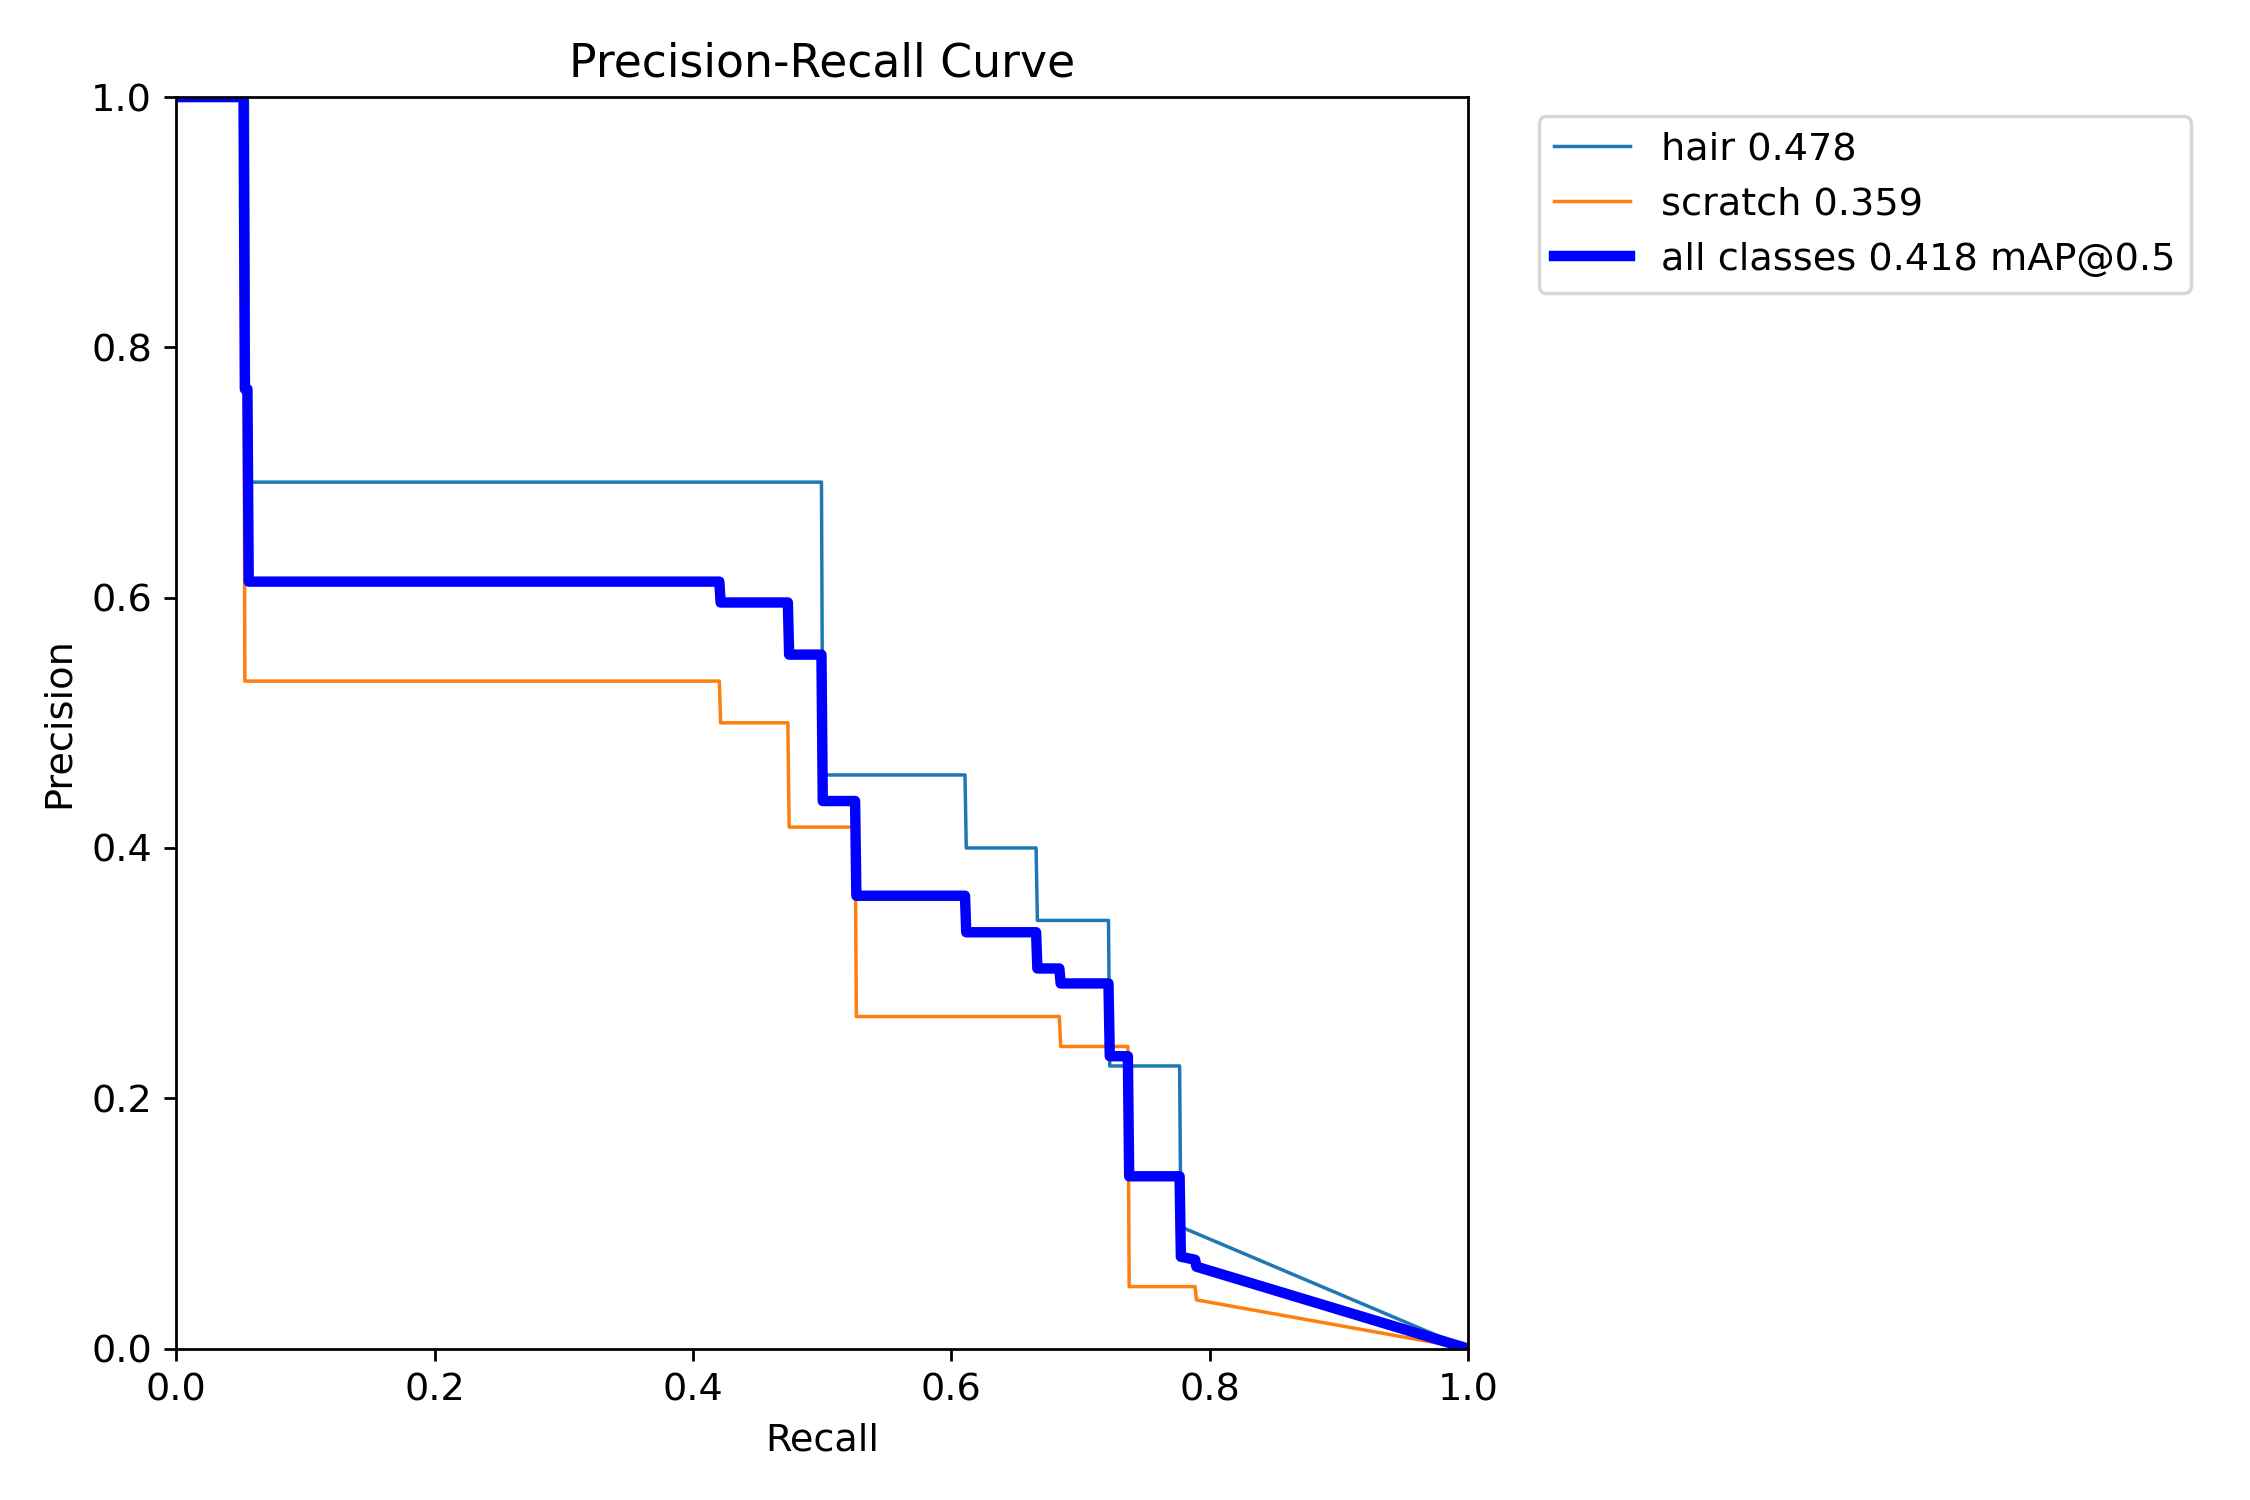

In [17]:
cv2_imshow(cv2.imread("/content/runs/detect/yolov8n_v8_1000e/PR_curve.png"))

## 🎸 Inference 🎸

On the validation set, the following values of metrics have been obtained:

Precision of Box = around 0.982
Recall of Box = around 1
mAP50 = around 0.995
mAP50-95 = around 0.874
Based on the evaluation metrics, the model is showing a decent performance which is also evident in the plotted images and their predicted bounding boxes.

From the plot of the prediction, it is observed that the Recall is high (100%) as all the guitar images have been identified by the model. However, there is some issue of Precision, as in a couple of images, the model has made double predictions for the same guitar image. It may have been caused due to the side ways view of the guitar. Note that, care was taken to annotate the images of guitar only for the front view of guitar even in case the side view was visible along with the front view. This has been done to prevent any confusion for the model.

The model is able to get a good mAP value which is a widely used object detection metric for object detection models. This implies that the model is making a prediction of the bounding box that has a large Intersection over Union with the ground truth annotations provided with the validation images.

## 🎸 Make predictions using the trained YOLOv8 model (yolov8n_v8_50e) on a set of images 🎸

!yolo: Run the YOLO task.

task=detect: Specify the type of task, which is detection in this case.

mode=predict: Indicate that the model will be used to make predictions.

model=/content/runs/detect/yolov8n_v8_50e/weights/best.pt: Specify the path to the trained YOLOv8 model's weights file. The path provided points to the best-performing weights checkpoint saved during training.

source=/content/drive/MyDrive/Guitar_dataset/val/images: Specify the source directory containing the images on which the inference is to be performed. These are the images from the validation dataset.

imgsz=640: Set the input image size for inference to 640x640 pixels. This ensures that the input images are resized to the specified size before passing them through the YOLOv8 model.

conf: Set the Confidence Threshold for detection.

name=yolov8n_v8_50e_infer640: Set a name for the inference run, which can be used to identify and organize the inference results.

In [15]:
!cp -r /content/gdrive/MyDrive/yolov8_iphone_hair_scratch/test /content

In [26]:
!rm -rf /content/yolov7_model

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [16]:
# Make predictions.

!yolo task=detect \
mode=predict \
model=/content/runs/detect/yolov8n_v8_1000e/weights/best.pt \
source=/content/test \
imgsz=640 \
conf=0.1 \
name=yolov8n_v8_50e_infer640

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs

image 1/7 /content/test/4072.jpg: 640x640 1 hair, 9.1ms
image 2/7 /content/test/Screenshot 2021-12-12 110148.jpg: 640x608 (no detections), 57.1ms
image 3/7 /content/test/autumn-decoration-hair-strands-png-clipart.jpg: 480x640 3 hairs, 59.1ms
image 4/7 /content/test/qjhmbgb2cqm21.jpg: 640x480 7 scratchs, 56.6ms
image 5/7 /content/test/rmb37b6zgb971.jpg: 640x384 2 scratchs, 62.5ms
image 6/7 /content/test/strands-2-stamps-black-line-illustration-png-clipart-thumbnail.jpg: 544x640 (no detections), 57.7ms
image 7/7 /content/test/tempImageLufYWN.jpg: 480x640 (no detections), 10.3ms
Speed: 3.1ms preprocess, 44.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/yolov8n_v8_50e_infer640
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
# Plot and visualize images in a 2x2 grid.

def visualize(result_dir, num_samples=20):
    """
    Function accepts a list of images and plots them in a 2x2 grid.
    """
    plt.figure(figsize=(100, 100))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(20, 1, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

In [ ]:
# Call the visualize function to view the predictions.

visualize('/content/runs/detect/yolov8n_v8_50e_infer640')

## 🎸 Conclusion 🎸

Overall, the tasks performed in the project include creation of the dataset, then the object (guitar) detection, and finally the evaluation of the model's performance. The performance of the model can be improved by increasing the number and variety of the images in the dataset. Also, the number of classes can be increased by annotating the present images for other classes and also including more images and labelling them.

In [23]:
!cp -r /content/runs /content/gdrive/MyDrive/yolov8_iphone_hair_scratch

In [ ]:
#testing yolov7 on test data

In [17]:
'''
!cp -r /content/gdrive/MyDrive/yolov7_iphone_hair_scratch/trained_result_model_v1/best.pt /content
!git clone https://github.com/WongKinYiu/yolov7

%cd yolov7
!python detect.py --weights /content/best.pt --conf 0.1 --source /content/test
'''